C:\Users\prshi\AppData\Local\Temp\ipykernel_1928\3689545093.py:58: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors = 'coerce').dt.date


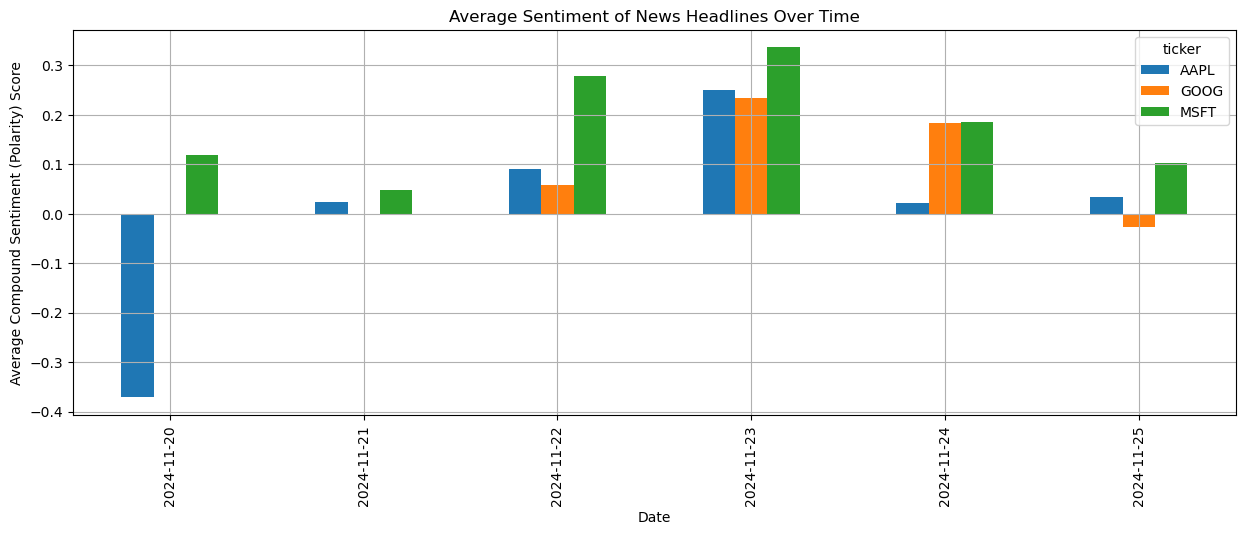

In [6]:
# Import necessary libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

finviz_url = 'https://finviz.com/quote.ashx?t=' #Defining finviz url
tickers = ['AAPL', 'GOOG', 'MSFT'] #Defining a list tickers containing ticker symbols

# Dictionary to store news tables for each ticker
news_tables = {}

# Scrape news data from Finviz for each ticker
for ticker in tickers:
    url = finviz_url + ticker 
    req = Request(url=url, headers={'User-Agent': 'Mozilla/5.0'}) #Requesting access to the url with the help of headers
    response = urlopen(req) #storing the response of the request in the response variable 
    html = BeautifulSoup(response, 'html.parser') #Parsing the response as html 
    news_table = html.find(id='news-table') #Finds the id inside the html 
    news_tables[ticker] = news_table #{T1:NT1, T2:NT2,T3:NT3}

# List of lists to store parsed news data
parsed_data = []

for ticker, news_table in news_tables.items():

    for row in news_table.findAll('tr'): #for loop for each row, tr stands for table rows
        title = row.a.get_text() #inside each tr, a (anchor) is present. Var "title" stores the headline text
        date_data = row.td.text #inside each tr, td(table data) is present, which contains date,time in form of text
        date_data_1 = date_data.rstrip() #removes trailing characters
        date_data_2 = date_data_1.lstrip() #removes extra spaces added at the beginning(if any)
        date_data_3 = date_data_2.split(" ") #creates a list of date and time

        if len(date_data_3) == 1: #Meaning that if only time is present
            time = date_data_3[0]
        else:
            date = date_data_3[0] #meaning that if both date and time is present
            time = date_data_3[1]

        parsed_data.append([ticker, date, time, title]) #Adding data to the parsed_data in form of list

# print(parsed_data)

# Create a DataFrame from parsed data
df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])

# Initialize VADER sentiment analyzer
vader = SentimentIntensityAnalyzer()

# Compute compound sentiment score for each news title
df['compound'] = df['title'].apply(lambda title: vader.polarity_scores(title)['compound'])
#Creates a new column 'compound' containing polarity score for each title

# Handle 'Today' in date column and convert to date format
# df['date'] = df['date'].replace('Today', datetime.today().strftime("%m-%d-%Y"))
df['date'] = pd.to_datetime(df['date'], errors = 'coerce').dt.date

# Group the DataFrame df by two columns: ticker and date, and calculate the mean of compound scores for each date
mean_df = df.groupby(['ticker', 'date']).mean(numeric_only=True)

mean_df = mean_df.unstack() #Here, ticker values become the columns, and date remains as the index

mean_df = mean_df.xs('compound', axis='columns').transpose()
# Here .xs() refers to cross section. This line is used to ensure that we are working with the 'compound' sentiment scores.
# .transpose = flips the DataFrame's rows and columns, making the dates the columns and the tickers the index.

# Plot average sentiment scores over time
mean_df.plot(kind='bar', figsize=(15, 5), grid=True)
plt.title('Average Sentiment of News Headlines Over Time')
plt.xlabel('Date')
plt.ylabel('Average Compound Sentiment (Polarity) Score')
plt.show()